In [ ]:
# 데이터셋 및 경로 설정
data_root = "/content/gdrive/MyDrive/dataset"
train_dir = os.path.join(data_root, "train")
val_dir = os.path.join(data_root, "validation")
test_dir = os.path.join(data_root, "test")

# 데이터 변환
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # 이미지 크기 조정
    transforms.ToTensor(),          # 이미지를 텐서로 변환
])

# 데이터 로더 설정
batch_size = 8
train_dataset = CustomDataset(train_dir, transform)
val_dataset = CustomDataset(val_dir, transform)
test_dataset = CustomDataset(test_dir, transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
sys.path.append("/content/drive/MyDrive/data")
import os
from tqdm import tqdm
from PIL import Image
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import torchvision
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cuda


In [ ]:
import os
import json
import matplotlib.pyplot as plt
# 데이터 파일 경로 설정

img_path = "/content/drive/MyDrive/data/2DSSs/training/images/고정밀_AGS_DA_00C_BA_220902_001058.jpg"
json_path = "/content/drive/MyDrive/data/2DSSs/training/labels/고정밀_AGS_DA_00C_BA_220902_001058.json"

image = plt.imread(img_path)
# 이미지 로드
# image = Image.open(img_path)

with open(json_path, 'r') as json_file:
    data = json.load(json_file)



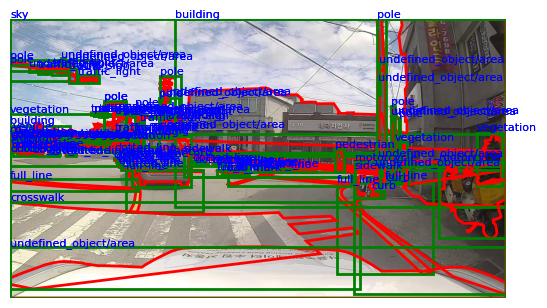

In [ ]:
# 이미지에 다각형 및 bbox 시각화
fig, ax = plt.subplots()
ax.imshow(image)

# 다각형과 bbox 그리기
for item in data["Annotation"]:
    if item["Type"] == "polygon":
        label = item["Label"]
        polygon_coords = item["Coordinate"][0]

        # 다각형 그리기
        x_coords = polygon_coords[0::2]
        y_coords = polygon_coords[1::2]
        polygon = patches.Polygon(xy=list(zip(x_coords, y_coords)), closed=True, linewidth=2, edgecolor='r', facecolor='none')

        # 레이블 추가
        plt.text(min(x_coords), min(y_coords) - 5, label, color='b', fontsize=8, backgroundcolor='none')

        # 다각형 시각화
        plt.gca().add_patch(polygon)

        # bbox 좌표
        x_min, y_min, width, height = item["bbox"]

        # 바운딩 박스 생성
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='g', facecolor='none')

        # # 레이블 추가
        plt.text(x_min, y_min - 5, label, color='b', fontsize=8, backgroundcolor='none')

        # 바운딩 박스 시각화
        plt.gca().add_patch(rect)

# 이미지 출력 설정
plt.axis('off')
plt.show()


In [ ]:
import os
import json
import numpy as np
from PIL import Image
from tqdm import tqdm

def load_data(data_dir):
    image_paths = sorted([f for f in os.listdir(os.path.join(data_dir, "images")) if f.endswith('.jpg')])
    data = []

    for img_filename in tqdm(image_paths, desc="Loading Data"):
        img_path = os.path.join(data_dir, "images", img_filename)
        json_filename = img_filename.replace(".jpg", ".json")
        json_path = os.path.join(data_dir, "labels", json_filename)

        image = np.array(Image.open(img_path))

        with open(json_path, 'r') as json_file:
            label_data = json.load(json_file)

        data.append((image, label_data))

    return data

data_dir = "/content/drive/MyDrive/data/2DSSs/training"
dataset = load_data(data_dir)

Loading Data: 100%|██████████| 800/800 [11:09<00:00,  1.19it/s]


In [ ]:
import tensorflow as tf

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
!pip install opencv-python

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

# 이미지 크기 설정
input_height, input_width = 256, 256  # 모델 입력 크기에 맞게 조정

def preprocess_data(data):
    images = []
    masks = []
    for image, label_data in data:
        # 이미지 크기 조정
        image = Image.fromarray(image).resize((input_width, input_height))

        # 라벨 데이터 처리
        mask = np.zeros((input_height, input_width), dtype=np.uint8)
        for annotation in label_data["Annotation"]:
          if annotation["Type"] == "polygon":
              polygon_coords = annotation["Coordinate"][0]
              # 좌표 번갈아가며 적용
              x_coords = polygon_coords[0::2]
              y_coords = polygon_coords[1::2]
              # points = list(zip(x_coords, y_coords))
              points = np.array(list(zip(x_coords, y_coords)), dtype=np.int32)
              mask = cv2.fillPoly(mask, [points], color=1)

        images.append(np.array(image))
        masks.append(mask)

    images = np.array(images)
    masks = np.array(masks)
    masks = masks[..., np.newaxis]  # 차원 추가

    return images, masks

# 데이터 전처리
train_data = dataset[:600]  # 적절한 훈련 데이터 개수 선택
val_data = dataset[600:700]
test_data = dataset[700:800]

train_images, train_masks = preprocess_data(train_data)
val_images, val_masks = preprocess_data(val_data)
test_images, test_masks = preprocess_data(test_data)

# 데이터 증강
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=[0.8, 1.2],
    fill_mode='nearest'
)

train_masks = np.expand_dims(train_masks, axis=-1)

# 데이터 제너레이터 생성
train_generator = datagen.flow(train_images, train_masks, batch_size=16, seed=42)

In [ ]:
# import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate

# # U-Net 모델 정의
# def unet(input_shape):
#     inputs = Input(input_shape)

#     # Contracting Path
#     conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
#     conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
#     pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

#     conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
#     conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
#     pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

#     # Middle Convolution
#     conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
#     conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)

#     # Expansive Path
#     up4 = UpSampling2D(size=(2, 2))(conv3)
#     up4 = Conv2D(128, 2, activation='relu', padding='same')(up4)
#     merge4 = concatenate([conv2, up4], axis=3)
#     conv4 = Conv2D(128, 3, activation='relu', padding='same')(merge4)
#     conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)

#     up5 = UpSampling2D(size=(2, 2))(conv4)
#     up5 = Conv2D(64, 2, activation='relu', padding='same')(up5)
#     merge5 = concatenate([conv1, up5], axis=3)
#     conv5 = Conv2D(64, 3, activation='relu', padding='same')(merge5)
#     conv5 = Conv2D(64, 3, activation='relu', padding='same')(conv5)

#     # Output Layer
#     outputs = Conv2D(1, 1, activation='sigmoid')(conv5)

#     model = Model(inputs=inputs, outputs=outputs)
#     return model

# # 모델 컴파일 및 학습
# input_shape = (None, None, 3)  # 입력 이미지의 크기에 따라 조정
# model = unet(input_shape)
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])






import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate

# U-Net 모델 정의
def unet(input_shape, dropout_rate=0.5):
    inputs = Input(input_shape)

    # Contracting Path
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Middle Convolution
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    drop3 = Dropout(dropout_rate)(conv3)  # 드롭아웃 추가

    # Expansive Path
    up4 = UpSampling2D(size=(2, 2))(drop3)  # 드롭아웃을 거친 feature map 사용
    up4 = Conv2D(128, 2, activation='relu', padding='same')(up4)
    merge4 = concatenate([conv2, up4], axis=3)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(merge4)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(dropout_rate)(conv4)  # 드롭아웃 추가

    up5 = UpSampling2D(size=(2, 2))(drop4)  # 드롭아웃을 거친 feature map 사용
    up5 = Conv2D(64, 2, activation='relu', padding='same')(up5)
    merge5 = concatenate([conv1, up5], axis=3)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(merge5)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(conv5)
    drop5 = Dropout(dropout_rate)(conv5)  # 드롭아웃 추가

    # Output Layer
    outputs = Conv2D(1, 1, activation='sigmoid')(drop5)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# 모델 컴파일 및 학습
input_shape = (None, None, 3)  # 입력 이미지의 크기에 따라 조정
model = unet(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 모델 학습
model.fit(train_images, train_masks, batch_size=16, epochs=10, validation_data=(val_images, val_masks))

Epoch 1/10
38/38 [==============================] - 69s 1s/step - loss: 0.9262 - accuracy: 0.9773 - val_loss: 9.9623e-04 - val_accuracy: 1.0000
Epoch 2/10
38/38 [==============================] - 29s 766ms/step - loss: 0.0080 - accuracy: 1.0000 - val_loss: 7.5741e-07 - val_accuracy: 1.0000
Epoch 3/10
38/38 [==============================] - 30s 778ms/step - loss: 5.1882e-04 - accuracy: 1.0000 - val_loss: 1.7182e-05 - val_accuracy: 1.0000
Epoch 4/10
10/38 [======>.......................] - ETA: 21s - loss: 0.0012 - accuracy: 0.9999

KeyboardInterrupt: ignored

In [ ]:
# 데이터 로드 및 전처리
# 여기서 데이터 로드 및 전처리 코드를 추가해야 합니다.
# -> 이미 시행

# 모델 학습
model.fit(train_images, train_masks, batch_size=16, epochs=10, validation_data=(val_images, val_masks))

# 학습된 모델 저장
model.save('unet_segmentation_model.h5')

Epoch 1/10
38/38 [==============================] - 30s 780ms/step - loss: 3.7812e-04 - accuracy: 1.0000 - val_loss: 1.4026e-05 - val_accuracy: 1.0000
Epoch 2/10
38/38 [==============================] - 30s 778ms/step - loss: 7.1052e-04 - accuracy: 1.0000 - val_loss: 3.1328e-05 - val_accuracy: 1.0000
Epoch 3/10
38/38 [==============================] - 29s 772ms/step - loss: 4.7724e-04 - accuracy: 1.0000 - val_loss: 8.5690e-06 - val_accuracy: 1.0000
Epoch 4/10
38/38 [==============================] - 29s 776ms/step - loss: 3.0406e-04 - accuracy: 1.0000 - val_loss: 3.1921e-05 - val_accuracy: 1.0000
Epoch 5/10
38/38 [==============================] - 30s 778ms/step - loss: 2.1491e-04 - accuracy: 1.0000 - val_loss: 2.3219e-10 - val_accuracy: 1.0000
Epoch 6/10
38/38 [==============================] - 29s 776ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 6.5074e-06 - val_accuracy: 1.0000
Epoch 7/10
38/38 [==============================] - 29s 775ms/step - loss: 3.1112e-04 - accuracy: 

4/4 [==============================] - 9s 224ms/step


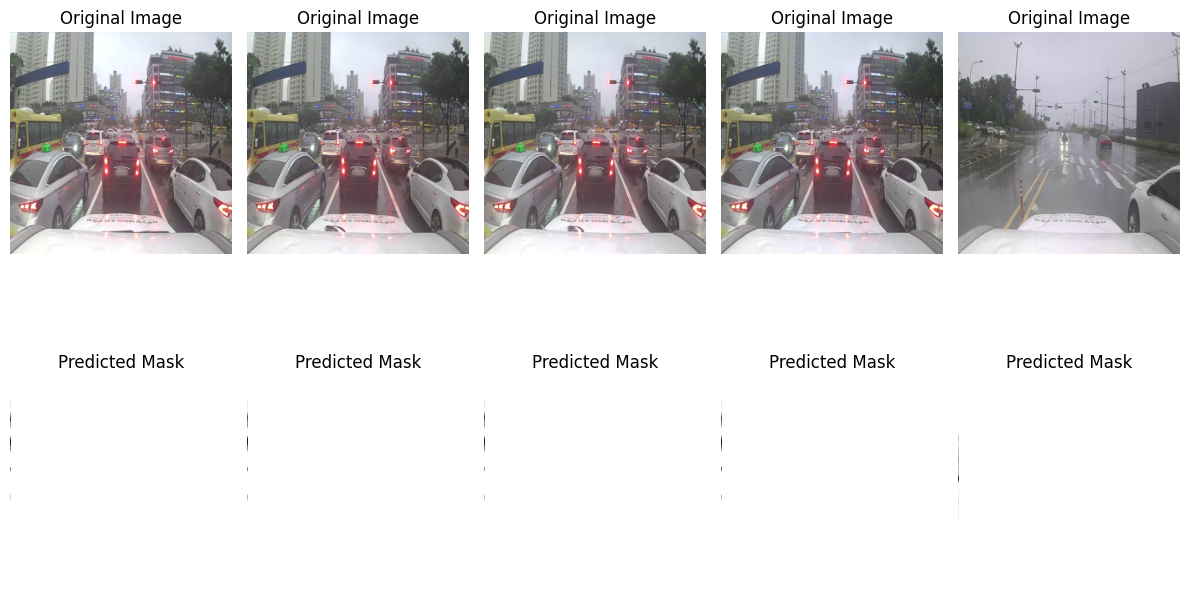

In [ ]:
from tensorflow.keras.models import load_model

# 저장된 모델 로드
loaded_model = load_model('unet_segmentation_model.h5')

# 새로운 이미지에 대한 예측 수행
predicted_masks = loaded_model.predict(test_images)

# 예측 결과 시각화 예시
plt.figure(figsize=(12, 8))
for i in range(5):  # 예시로 5개 이미지만 시각화
    plt.subplot(2, 5, i+1)
    plt.imshow(test_images[i])
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(2, 5, i+6)
    plt.imshow(predicted_masks[i].squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

plt.tight_layout()
plt.show()